### import

In [31]:
import numpy as np 
import pandas as pd 
import sys 
import os 
import logzero 
import wandb 
import pickle 
import seaborn as sns 
sns.set()

In [2]:
from src.utils import noglobal, pickle_load, pickle_save, HydraConfig

### config

In [3]:
class Config():
    version = '001'
    comment = 'test'
    input_dir = '/home/user/work/input/'
    output_dir = f'/home/user/work/output/{version}/' 
    seed = 42
    target_col = 'label'
    wandb_init = {
        "project": "debug",
        "entity": "kuto5046",
        "group": f"exp{version}",
        "dir": output_dir,
        "tags": [],
        "mode": "disabled", 
    }

    # model設定読み込み
    model_config_name = 'cb_binary'  # タスクや使うモデルに応じて変更
    model_config = HydraConfig.get_cnf(config_path='/home/user/work/configs/model/', config_name=model_config_name)
    num_boost_round = model_config['num_boost_round']
    model_name = model_config.name
    model_params = dict(model_config['params'])

    

c = Config()
# c = HydraConfig.get_cnf(config_path='/home/user/work/configs/', config_name='config.yaml')
os.makedirs(c.output_dir, exist_ok=True)
logger = logzero.setup_logger(name='main', logfile=f'{c.output_dir}/result.log', level=10)

/opt/conda/lib/python3.8/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'cb_binary': Defaults list is missing `_self_`. See https://hydra.cc/docs/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [4]:
# 念の為check
c.model_name, c.num_boost_round, c.model_params

('catboost-classifier',
 'None',
 {'loss_function': 'Logloss',
  'eval_metric': 'Logloss',
  'num_boost_round': 3000,
  'colsample_bylevel': 0.8,
  'max_depth': 5,
  'subsample': 0.8,
  'random_seed': 42,
  'learning_rate': 0.05})

### read data

In [5]:
train = pd.read_csv(f'{c.input_dir}/train.csv')
test = pd.read_csv(f'{c.input_dir}/test.csv')
train.shape, test.shape

((232785, 4), (125346, 3))

### preprocess

In [6]:
from src.features.base import Feature, generate_features, get_categorical_col, get_numerical_col, load_datasets
from src.features.encoder import count_encoder, ordinal_encoder, pp_for_categorical_encoding, target_encoder
from src.features.nlp import count_lda_vectorize, tfidf_svd_vectorize, UniversalSentenceEncoder, BertSequenceVectorizer, Sentence2Vec, SCDVEmbedder

2022-10-03 13:34:53.011437: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-03 13:34:53.124892: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-03 13:34:53.563263: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.8/site-packages/torch/lib:/opt/conda/lib/python3.8/site-packages/torch_tensorrt/lib:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-10-03 13:34:53.563313: W te

In [7]:
whole = pd.concat([train, test]).reset_index(drop=True)
whole = pd.concat([whole, whole['code'].str.split('\n', expand=True).add_prefix('code_')], axis=1)

for i in range(5):
    whole[f'code_{i}'] = whole[f'code_{i}'].str.strip()

cat_cols = get_categorical_col(whole, skip_cols=['id', c.target_col])
numerical_cols = get_numerical_col(whole, skip_cols=['id', c.target_col])

In [8]:
cat_cols

['code', 'file_extension', 'code_0', 'code_1', 'code_2', 'code_3', 'code_4']

In [9]:
numerical_cols

[]

In [10]:
train = whole[~whole[c.target_col].isna()].reset_index(drop=True)
test = whole[whole[c.target_col].isna()].reset_index(drop=True)

In [11]:
train, test = pp_for_categorical_encoding(train, test, cat_cols)

### feature engineering

In [12]:
class TfidfSvdCode2(Feature):
    def create_features(self):
        col = 'code_2'
        self.train = tfidf_svd_vectorize(train, col=col)
        self.test = tfidf_svd_vectorize(test, col=col)

# class CoundLDACode2(Feature):
#     def create_features(self):
#         col = 'code_2'
#         self.train = count_lda_vectorize(train, col=col)
#         self.test = count_lda_vectorize(test, col=col)


class OrdinalEncode(Feature):
    def create_features(self):
        self.train, self.test = ordinal_encoder(train, test, cat_cols)


class BertVecCode2(Feature):
    def create_features(self):
        bert = BertSequenceVectorizer()
        col = 'code_2'
        self.train = bert.vectorize_to_df(train, col)
        self.test = bert.vectorize_to_df(test, col)


class USEncodeCode2(Feature):
    def create_features(self):
        col = 'code_2'
        usencoder = UniversalSentenceEncoder()
        self.train = usencoder.vectorize(train, col)
        self.test = usencoder.vectorize(test, col)


# class Sentence2VecCode2(Feature):
#     def create_features(self):
#         col = 'code_2'
#         encoder = Sentence2Vec()
#         self.train = encoder.vectorize_to_df(train, col)
#         self.test = encoder.vectorize_to_df(test, col)

In [13]:
ext = 'pickle'
generate_features(globals(), ext=ext, overwrite=False)

TfidfSvdCode2 was skipped
OrdinalEncode was skipped
BertVecCode2 was skipped
USEncodeCode2 was skipped


In [14]:
feats = [
    # 'TfidfSvdCode2',
    'OrdinalEncode',
    # 'CoundLDACode2',
    # 'USEncodeCode2',
    # 'BertVecCode2'
]
train_data, test_data = load_datasets(feats, ext=ext)

In [15]:
cat_cols = get_categorical_col(train_data)
cat_cols 

['code_ordinal_enc',
 'file_extension_ordinal_enc',
 'code_0_ordinal_enc',
 'code_1_ordinal_enc',
 'code_2_ordinal_enc',
 'code_3_ordinal_enc',
 'code_4_ordinal_enc']

In [16]:
# 使用する特徴量&label
for f in train_data.columns:
    print(f)

code_ordinal_enc
file_extension_ordinal_enc
code_0_ordinal_enc
code_1_ordinal_enc
code_2_ordinal_enc
code_3_ordinal_enc
code_4_ordinal_enc


In [17]:
train_data[c.target_col] = train[c.target_col].to_numpy()

### cv

In [18]:
from src.cv import get_kfold, get_stratifiedkfold, get_groupkfold
cv = get_stratifiedkfold(train_data, c.target_col, n_splits=5)
cv

[(array([     0,      1,      2, ..., 232782, 232783, 232784]),
  array([     6,     10,     15, ..., 232756, 232764, 232767])),
 (array([     0,      1,      3, ..., 232781, 232782, 232783]),
  array([     2,      4,      7, ..., 232773, 232779, 232784])),
 (array([     0,      2,      3, ..., 232782, 232783, 232784]),
  array([     1,      5,     12, ..., 232765, 232777, 232781])),
 (array([     0,      1,      2, ..., 232781, 232782, 232784]),
  array([     8,     27,     33, ..., 232778, 232780, 232783])),
 (array([     1,      2,      4, ..., 232781, 232783, 232784]),
  array([     0,      3,      9, ..., 232772, 232774, 232782]))]

### callback

In [19]:
from src.models import get_callbacks
callbacks = get_callbacks(c.model_name)
callbacks

[]

### model

In [20]:
from src.models import get_model # , LGBModel, XGBModel, CBModel 

model = get_model(c.model_name, c.model_params, c.num_boost_round, cat_cols, c.output_dir, callbacks)

### train

In [21]:
from sklearn.metrics import f1_score, roc_auc_score
def calc_score(true, pred):
    return roc_auc_score(true, pred)

In [22]:
def train_pipeline(model, train, test, cv, config, cat_cols, target_col):
    oofs = []
    preds = []
    for i, (idx_train, idx_valid) in enumerate(cv):
        wandb.init(**config.wandb_init, name=f'exp{config.version}-fold{i}')

        if i not in [0]:
            break 

        logger.info("############")
        logger.info(f"fold {i}")
        logger.info("############")

        _train = train.loc[idx_train].reset_index(drop=True)
        _valid = train.loc[idx_valid].reset_index(drop=True)

        # target encoding
        # for col in cat_cols:
        #     _train, _valid = target_encoder(_train, _valid, col, target_col)
        #     _, test = target_encoder(train, test, col, target_col)

        X_train = _train.drop(target_col, axis=1)
        y_train = _train[target_col]
        X_valid = _valid.drop(target_col, axis=1)
        y_valid = _valid[target_col]
        X_test = test

        model.train(X_train, y_train, X_valid, y_valid)
        model.save(i)
        pred = model.predict(X_valid)

        # evaluate
        score = calc_score(y_valid, pred)
        logger.info(f'fold-{i} score: {score}')
        wandb.log({'CV': score})

        # create oof
        oof_df = pd.DataFrame(pred, index=idx_valid)
        oofs.append(oof_df)

        # pred
        pred_test = model.predict(X_test)
        np.save(f"{c.output_dir}/pred_test_{i}", pred_test)
        preds.append(pred_test)

        if i!=len(cv)-1:
            wandb.finish()

    # oofを保存
    oof = np.array(pd.concat(oofs).sort_index())
    np.save(f"{c.output_dir}/oof", oof)
    return model, oof

In [23]:
model, oof = train_pipeline(model, train_data, test_data, cv, c, cat_cols, c.target_col)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
[I 221003 13:35:00 2254651400:10] ############
[I 221003 13:35:00 2254651400:11] fold 0
[I 221003 13:35:00 2254651400:12] ############


0:	learn: 0.6848512	test: 0.6849093	best: 0.6849093 (0)	total: 89.4ms	remaining: 4m 28s
100:	learn: 0.5255344	test: 0.5068115	best: 0.5068115 (100)	total: 2.08s	remaining: 59.8s
200:	learn: 0.5195309	test: 0.4997104	best: 0.4997104 (200)	total: 5.3s	remaining: 1m 13s
300:	learn: 0.5168083	test: 0.4969925	best: 0.4969925 (300)	total: 8.69s	remaining: 1m 17s
400:	learn: 0.5149664	test: 0.4954161	best: 0.4954161 (400)	total: 12.3s	remaining: 1m 19s
500:	learn: 0.5136894	test: 0.4945118	best: 0.4945118 (500)	total: 15.7s	remaining: 1m 18s
600:	learn: 0.5125460	test: 0.4938712	best: 0.4938712 (600)	total: 19.1s	remaining: 1m 16s
700:	learn: 0.5116606	test: 0.4933629	best: 0.4933629 (700)	total: 22.7s	remaining: 1m 14s
800:	learn: 0.5108405	test: 0.4930037	best: 0.4930037 (800)	total: 26.5s	remaining: 1m 12s
900:	learn: 0.5101247	test: 0.4926390	best: 0.4926365 (899)	total: 29.9s	remaining: 1m 9s
1000:	learn: 0.5094735	test: 0.4923777	best: 0.4923777 (1000)	total: 33.7s	remaining: 1m 7s
1100

[I 221003 13:36:49 2254651400:34] fold-0 score: 0.6379306187057814


In [ ]:
from src.visualize import plot_importance
# catboostは対応していない
plot_importance(model.models, output_dir=c.output_dir)

### inference

In [25]:
preds = []
for i in range(len(cv)):
    pred = np.load(f'{c.output_dir}/pred_test_{i}.npy')
    preds.append(pred)
pred_test = np.mean(preds, axis=0)

### submission

In [26]:
sub = pd.read_csv(f'{c.input_dir}/sample_submission.csv')
sub['label'] = pred_test
sub.to_csv(f'{c.output_dir}/submission_exp{c.version}.csv', index=False)

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='label', ylabel='Density'>

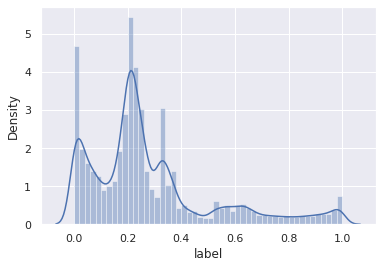

In [32]:
sns.distplot(sub['label'])